# Jupyter Notebook Workflow

1. Data curation and clean up
2. Run Nonadditivity Analysis
3. Generate Plots


In [1]:
import rdkit
from rdkit import Chem
from rdkit import Geometry
from rdkit import rdBase
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MolStandardize
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize.standardize import canonicalize_tautomer_smiles
from rdkit.Chem import rdFMCS
rdBase.DisableLog('rdApp.info')
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
from scipy.stats import normaltest
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import multiprocessing as mp
from multiprocessing import Process, Pipe

from nonadditivity_az.utils import process
from nonadditivity_az.plotting import *

In [2]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats("svg")

/var/folders/f8/snw3tlcs0y3bmnq5gqg26b5h0000gn/T/ipykernel_84508/669929949.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


### Set path for reading and writing data

In [3]:
my_path = './naa/ChEMBL_1614027/'
name = 'ChEMBL_1614027'

# <font color='crimson'>STEP I</font>

# Data Curation

* Data example for ChEMBL1614027

In [4]:
infile = f'{name}_curated.csv'
if os.path.exists(infile):
    df = pd.read_csv(infile)
else:
    # Apply all of the above functionalities and save file
    data = pd.read_csv(f'{name}.gz', compression='gzip', header=0, sep=';', error_bad_lines=False)
    df = process(data)
    df.to_csv(infile, index = False)

# <font color='crimson'>  STEP II

# NAA

- Code available from gitHub by Christian Kramer: https://github.com/KramerChristian/NonadditivityAnalysis
- Corresponding publication: https://pubs.acs.org/doi/abs/10.1021/acs.jcim.9b00631

In [5]:
def naa(infile, outfile, myprops, myunit, mydelim='comma', myseries=''):
    print ("\nanalyzing: ", infile)
    
    if os.path.exists(outfile):
        return outfile

    if myseries != '':
        print ('\n\n', 'python -m nonadditivity -in ', infile ,' -delimiter ', mydelim , ' -series_column ', myseries, ' -props ', myprops ,' -units ', myunit ,' -out ', outfile, '\n\n')
        !python -m nonadditivity -in {infile} -delimiter {mydelim} -series_column {myseries} -props {myprops} -units {myunit} -out {outfile}
    else:
        print ('\n\n', 'python -m nonadditivity -in', infile ,' -delimiter ', mydelim ,' -props ', myprops ,' -units ', myunit ,' -out ', outfile, '\n\n')
        !python -m nonadditivity -in {infile} -delimiter {mydelim} -props {myprops} -units {myunit} -out {outfile}

    print ("Done analysing.\n")
    return outfile

### Run NAA on cleanup data set

In [6]:
outfile = f'{name}_NAA_output.csv'

naa(infile, outfile, 'VALUE', 'noconv', 'comma')


analyzing:  ChEMBL_1614027_curated.csv


'ChEMBL_1614027_NAA_output.csv'

# <font color='crimson'> STEP III

### Generate plots for analysing NAA output

###  <font color='crimson'> * adjust thresholds based on the experimental uncertainty
    
- Experimental uncertainty estimates can be derived from NAA 

In [8]:
add_thrs = 0
exp_noise = 0.5
significant_thrs = 2*exp_noise
strong_thrs = 2*significant_thrs

In [9]:
MAIN = pd.read_csv(outfile, sep='\t')
MAIN.head()

,Compound1,Compound2,Compound3,Compound4,SMILES1,SMILES2,SMILES3,SMILES4,Series,Transformation1,Transformation2,Property,Prop_Cpd1,Prop_Cpd2,Prop_Cpd3,Prop_Cpd4,Nonadditivity,Circle_ID,Theo_Quantile
0,CHEMBL1555369,CHEMBL1330718,CHEMBL1531070,CHEMBL1442087,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(Cl)cc1)c1ccc(C(...,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(Cl)cc1)c1ccccc1,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(C(F)(F)F)cc1)c1...,CCC/C=C(\CCC)C(NS(=O)(=O)c1ccc(C(F)(F)F)cc1)c1...,,[*:1]C(=O)OC>>[*:1][H],[*:1]Cl>>[*:1]C(F)(F)F,VALUE,5.5,5.6,5.1,5.5,-0.5,CHEMBL1555369_CHEMBL1330718_CHEMBL1531070_CHEM...,-0.894
1,CHEMBL1486399,CHEMBL1396358,CHEMBL1566556,CHEMBL1398066,CCCC[C@@H]1C[C@H]1C(NC(=O)c1ccco1)c1ccccc1,CCCC/C=C/C(NC(=O)c1ccco1)c1ccccc1,CCCC/C=C/C(NC(=O)c1ccccc1)c1ccccc1,CCCC[C@@H]1C[C@H]1C(NC(=O)c1ccccc1)c1ccccc1,,[*:1][C@@H]1C[C@H]1CCCC>>[*:1]/C=C/CCCC,[*:1]c1ccco1>>[*:1]c1ccccc1,VALUE,4.8,4.8,5.0,5.1,-0.1,CHEMBL1486399_CHEMBL1396358_CHEMBL1566556_CHEM...,-0.165
2,CHEMBL1359291,CHEMBL1437906,CHEMBL1403280,CHEMBL1592533,Cn1cccc1C(=O)N1CCC2(CC1)CCN(c1ccccn1)CC2,Cn1cccc1C(=O)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,COc1ccc(C(=O)N2CCC3(CCN(Cc4ccncc4)CC3)CC2)cc1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,,[*:1]c1ccccn1>>[*:1]Cc1ccncc1,[*:1]c1cccn1C>>[*:1]c1ccc(OC)cc1,VALUE,4.5,5.0,5.1,4.4,0.2,CHEMBL1359291_CHEMBL1437906_CHEMBL1403280_CHEM...,0.324
3,CHEMBL1564545,CHEMBL1403280,CHEMBL1592533,CHEMBL1315700,O=C(c1ccncc1)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,COc1ccc(C(=O)N2CCC3(CCN(Cc4ccncc4)CC3)CC2)cc1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,O=C(c1ccncc1)N1CCC2(CC1)CCN(c1ccccn1)CC2,,[*:1]c1ccncc1>>[*:1]c1ccc(OC)cc1,[*:1]Cc1ccncc1>>[*:1]c1ccccn1,VALUE,4.7,5.1,4.4,5.0,-1.0,CHEMBL1564545_CHEMBL1403280_CHEMBL1592533_CHEM...,-1.520
4,CHEMBL1359291,CHEMBL1315700,CHEMBL1564545,CHEMBL1437906,Cn1cccc1C(=O)N1CCC2(CC1)CCN(c1ccccn1)CC2,O=C(c1ccncc1)N1CCC2(CC1)CCN(c1ccccn1)CC2,O=C(c1ccncc1)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,Cn1cccc1C(=O)N1CCC2(CCN(Cc3ccncc3)CC2)CC1,,[*:1]c1cccn1C>>[*:1]c1ccncc1,[*:1]c1ccccn1>>[*:1]Cc1ccncc1,VALUE,4.5,5.0,4.7,5.0,-0.8,CHEMBL1359291_CHEMBL1315700_CHEMBL1564545_CHEM...,-1.330


In [10]:
MAIN['Nonadditivity_abs'] = MAIN['Nonadditivity'].abs()
MAIN_log0 = MAIN[MAIN['Nonadditivity_abs'] > add_thrs]
MAIN_log1 = MAIN[MAIN['Nonadditivity_abs'] > significant_thrs]
MAIN_log2 = MAIN_log1[MAIN_log1['Nonadditivity_abs'] > strong_thrs]

In [11]:
PC_PATH = f'{name}_NAA_output_perCompound.txt'
PC = pd.read_csv(PC_PATH, sep='\t')

PC['Nonadd_abs'] = PC['Nonadd_pC'].abs()
PC['CI'] = (2*2*exp_noise/(np.sqrt(PC['nOccurence'])))
PC['CI_2'] = (2*2*exp_noise/(np.sqrt(PC['nOccurence'])))*3
PC = PC.sort_values(by=['CI'], ascending=False)

PC_log0 = PC[PC['Nonadd_abs'] > add_thrs]
PC_log1 = PC[PC['Nonadd_abs'] > significant_thrs]
PC_log2 = PC_log1[PC_log1['Nonadd_abs'] > strong_thrs]

In [12]:
print(len(df.iloc[:,0]), 'compounds')
print(len(MAIN.iloc[:,0]), 'cycles')
print(len(MAIN_log1.iloc[:,0]), 'cycles with significant NA score', '(',round(len(MAIN_log1.iloc[:,0])/len(MAIN.iloc[:,0])*100,1), '% )')
print(len(PC_log1['Compound_ID'].value_counts()), 'unique compounds show significant NA shift', '(',round(len(PC_log1['Compound_ID'])/len(df.iloc[:,0])*100,1), '% )')
print(len(PC_log2['Compound_ID'].value_counts()), 'unique compounds show strong NA', '(',round(len(PC_log2['Compound_ID'])/len(df.iloc[:,0])*100,1), '% )')

2876 compounds
4086 cycles
486 cycles with significant NA score ( 11.9 % )
76 unique compounds show significant NA shift ( 2.6 % )
13 unique compounds show strong NA ( 0.5 % )


### Check for normality 

In [13]:
MAIN_array = MAIN['Nonadditivity'].values
stats.describe(MAIN_array, axis=0)

DescribeResult(nobs=4086, minmax=(-3.7, 4.2), mean=0.01216348608582966, variance=0.5283979081361584, skewness=0.08218443902894183, kurtosis=3.2170726148967947)

In [14]:
stat, p = normaltest(MAIN_array)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=317.363, p=0.000
Sample does not look Gaussian (reject H0)


### Nonadditivity Distribution

<font color='crimson'>normal distribution parameters depend on significant treshold

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


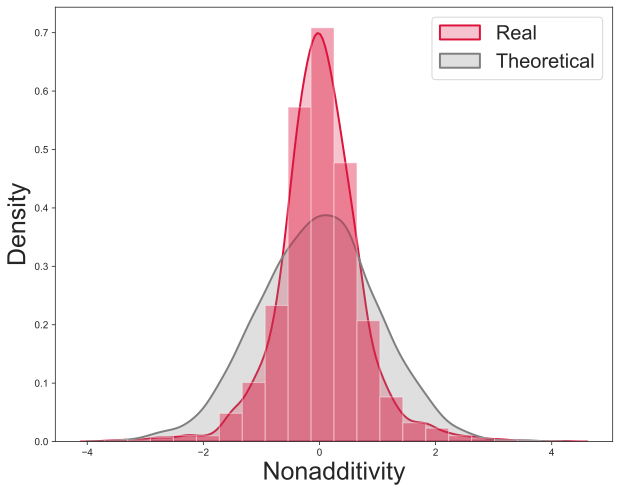

In [16]:
n_of_cycles = len(MAIN.iloc[:,0])
normal_dist = np.random.normal(loc=0,scale=significant_thrs,size=n_of_cycles)

NA_distribution(MAIN['Nonadditivity'], normal_dist)

### Detect outliers

In [17]:
ambiguous_compounds = PC.loc[PC['Nonadd_abs'] > PC['CI']]
print(len(ambiguous_compounds.iloc[:,0]), 'compounds')
outliers = ambiguous_compounds[['SMILES']]

#outliers.to_csv(my_path+'outliers.csv', index = False)

168 compounds


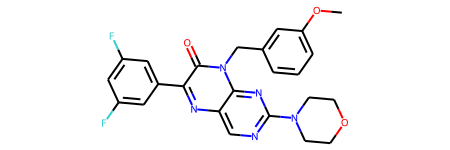

In [18]:
ambiguous_compounds = ambiguous_compounds.sort_values('Nonadd_abs')
SMILES = list(ambiguous_compounds['SMILES'])
strangest = SMILES[-2]

display(Chem.MolFromSmiles(strangest))

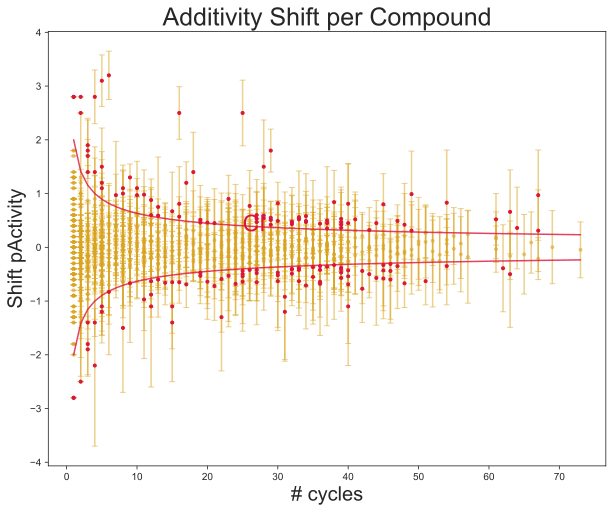

In [19]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('# cycles', fontsize=20)
ax.set_ylabel('Shift pActivity', fontsize=20)
ax.set_title('Additivity Shift per Compound', fontsize=25)

x = PC['nOccurence'].values
y = PC['Nonadd_pC'].values
e = PC['Nonadd_SD'].values
y_CI = PC['CI'].values
y_CI_2 = PC['CI_2'].values
x2 = ambiguous_compounds['nOccurence'].values
y2 = ambiguous_compounds['Nonadd_pC'].values
e2 = ambiguous_compounds['Nonadd_SD'].values

ax.errorbar(x, y, zorder=1, linestyle='None', yerr=e, alpha=0.5, capsize=3, color='goldenrod', marker='.')
ax.plot(x,y_CI, zorder=2, color='crimson', alpha=0.8, label= 'CI')
plt.text(25, 0.3, 'CI', fontsize=23, color='crimson')
ax.plot(x,y_CI*(-1), zorder=3, color='crimson', alpha=0.8)
ax.errorbar(x2, y2, zorder=1, linestyle='None', capsize=3, color='crimson', marker='.')

plt.show()

### Check outliers 

1. value
2. measurement frequency

In [20]:
ambiguous_compounds = ambiguous_compounds[['Compound_ID', 'Measured', 'nOccurence', 'Nonadd_pC']]
ambiguous_compounds = ambiguous_compounds.rename(columns=({'Compound_ID':'ID'}))
ambiguous_compounds = pd.merge(ambiguous_compounds, df, on='ID')
ambiguous_compounds = ambiguous_compounds[['ID', 'VALUE', 'nOccurence', 'Nonadd_pC']]

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


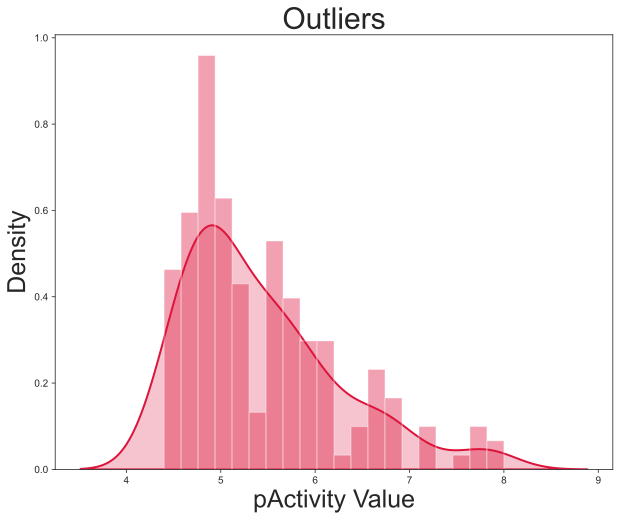

In [22]:
plot_outliers(ambiguous_compounds['VALUE'], 'Outliers')

### Compounds with Significant Additivity Shift
* significant = 2 times the experimental uncertainty

In [23]:
sign_NA_PC = PC_log1[['Compound_ID', 'Nonadd_pC']]
sign_NA_PC = sign_NA_PC.rename(columns=({'Compound_ID':'ID'}))
sign_NA_PC = pd.merge(sign_NA_PC, df, on='ID')
sign_NA_PC = sign_NA_PC[['ID', 'VALUE', 'Nonadd_pC']]

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


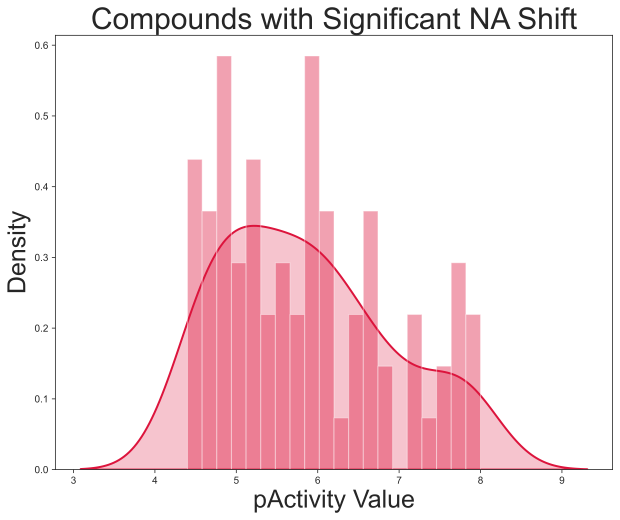

In [24]:
my_title = 'Compounds with Significant NA Shift'
plot_outliers(sign_NA_PC['VALUE'])

/Users/cthoyt/.virtualenvs/cheminf/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


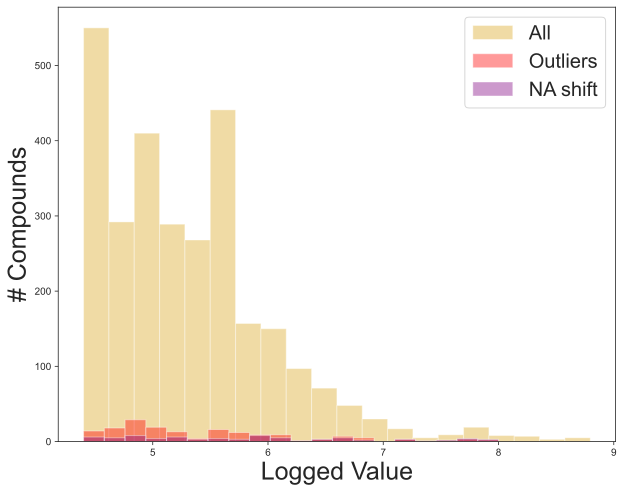

In [25]:
sns.set_style('ticks')
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10, 8)
sns.distplot(df['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='goldenrod',
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(ambiguous_compounds['VALUE'], hist=True, norm_hist=False, kde=False,
             color='red', bins=int(100/5),
             kde_kws={'shade': True, 'linewidth': 2})
sns.distplot(sign_NA_PC['VALUE'], hist=True, norm_hist=False, kde=False,
             bins=int(100/5), color='purple',
             kde_kws={'shade': True, 'linewidth': 2})

legend = ['All','Outliers', 'NA shift']

plt.legend(legend, prop={'size': 20}) #title = '')
plt.title('',  size=30)
plt.xlabel('Logged Value',  size=25)
plt.ylabel('# Compounds',  size=25)
plt.show()

### Compounds with strong nonadditivity shift

* more than 2 times significance threshold

In [26]:
strong_NA_PC = PC_log2[['Compound_ID', 'Nonadd_pC']]
strong_NA_PC = strong_NA_PC.rename(columns=({'Compound_ID':'ID'}))
strong_NA_PC = pd.merge(strong_NA_PC, df, on='ID')
strong_NA_PC = strong_NA_PC[['ID', 'VALUE', 'Nonadd_pC', 'MEASUREMENT']]

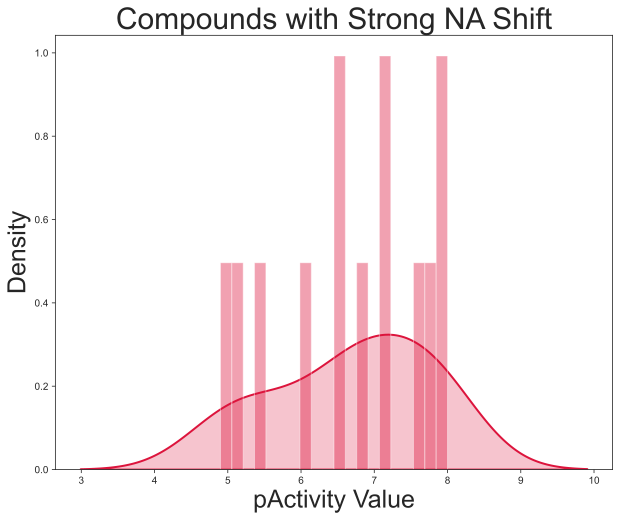

In [27]:
my_title = 'Compounds with Strong NA Shift'
plot_outliers(strong_NA_PC['VALUE'])

### Double-mutant cycles

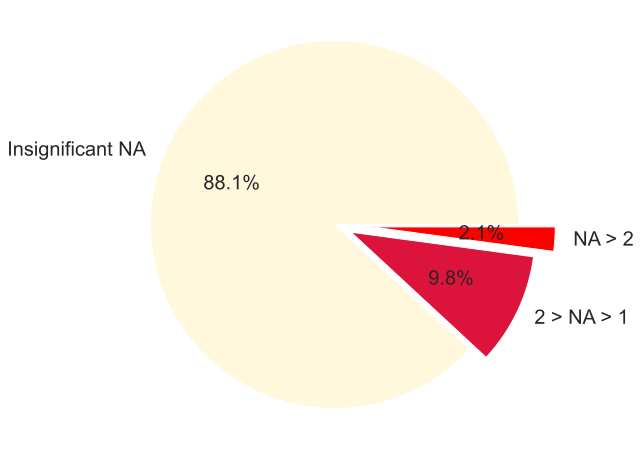

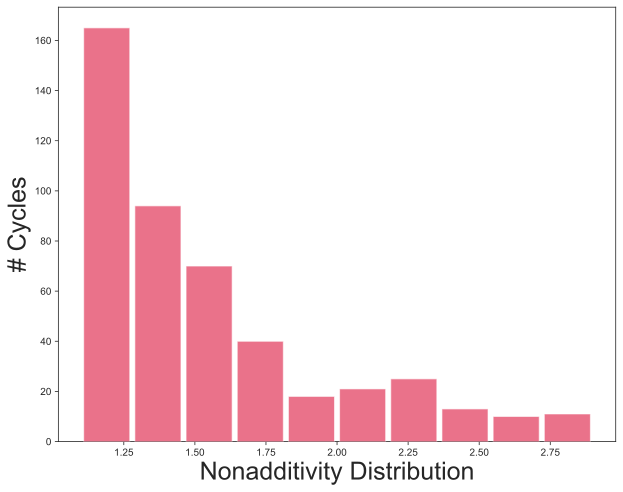

In [28]:
insignificant = len(MAIN.iloc[:,0]) - len(MAIN_log1.iloc[:,0])
treashold_1 = len(MAIN_log1.iloc[:,0]) - len(MAIN_log2.iloc[:,0])
treashold_2 = len(MAIN_log2.iloc[:,0])
labels = ["Insignificant NA", "2 > NA > 1", "NA > 2"]   
sizes = [insignificant, treashold_1, treashold_2]
explode = [0,0.1,0.2]
colors = ['cornsilk', 'crimson', 'red']  
fig = plt.figure(figsize = (8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.axis('equal')
plt.show()

hist = MAIN_log1[MAIN_log1['Nonadditivity_abs'] < 3]

ax = hist.hist(column= 'Nonadditivity_abs', bins=10, figsize=(10,8), color='crimson', alpha=0.6, zorder=10, rwidth=0.9)

ax = ax[0]
for x in ax:
    x.grid(alpha=0)
    x.set_title("", size=25)
    x.set_xlabel("Nonadditivity Distribution", size=25)
    x.set_ylabel("# Cycles", size=25)

### NAA per compound

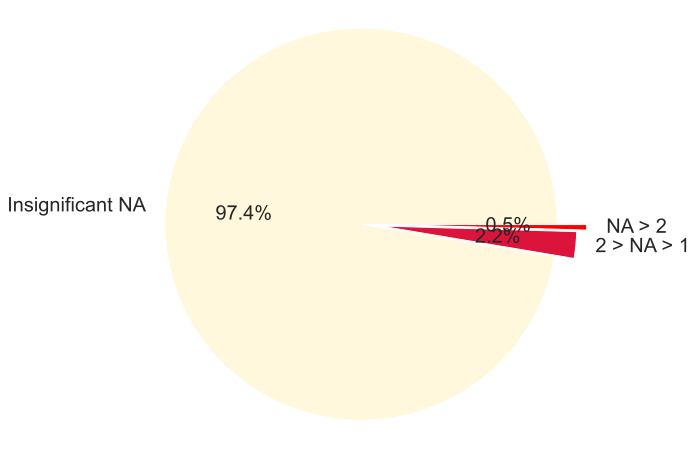

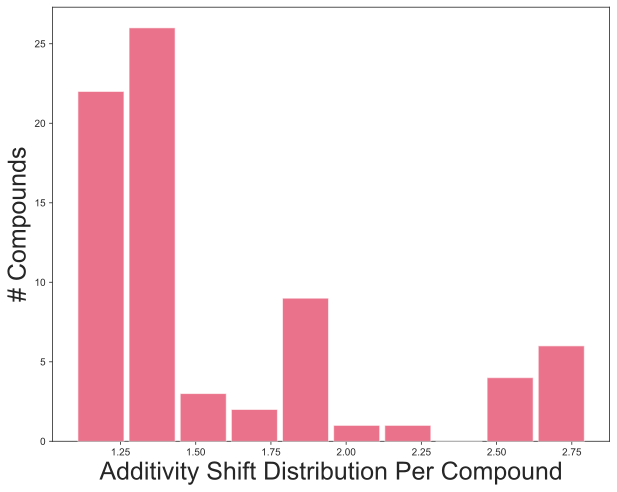

In [29]:
No_NA = len(df['ID'].value_counts()) - len(PC['Compound_ID'].value_counts())
No_significant =  len(PC['Compound_ID'].value_counts()) - len(PC_log1['Compound_ID'].value_counts()) + No_NA
treashold_1 = len(PC_log1['Compound_ID'].value_counts()) - len(PC_log2['Compound_ID'].value_counts())
treashold_2 = len(PC_log2['Compound_ID'].value_counts())

labels = ["Insignificant NA", "2 > NA > 1", "NA > 2"]   
sizes = [No_significant, treashold_1, treashold_2]
colors = ['cornsilk', 'crimson', 'red']
explode = [0,0.1,0.15]

fig = plt.figure(figsize = (8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', textprops={'fontsize': 20})
plt.axis('equal')
plt.show()

PC_hist = PC_log1[PC_log1['Nonadd_abs'] < 3]

ax = PC_hist.hist(column= 'Nonadd_abs', bins=10, figsize=(10,8), color='crimson', alpha=0.6, zorder=10, rwidth=0.9)

ax = ax[0]
for x in ax:
    x.grid(alpha=0)
    x.set_title("", size=25)
    x.set_xlabel("Additivity Shift Distribution Per Compound", size=25)
    x.set_ylabel("# Compounds", size=25)

### Plot images of highest NA score

* Code taken from https://github.com/KramerChristian/NonadditivityAnalysis

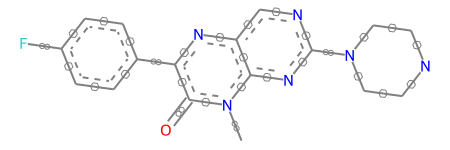

RDKit WARNING: [14:20:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:29] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [14:20:29] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:29] WARNING: not removing hydrogen atom with dummy atom neighbors


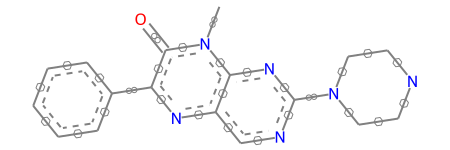

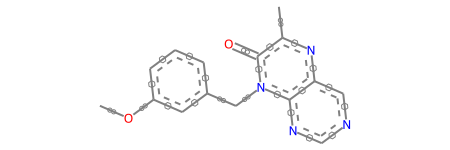

RDKit WARNING: [14:20:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:34] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [14:20:34] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:34] WARNING: not removing hydrogen atom with dummy atom neighbors


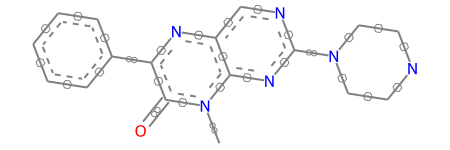

RDKit WARNING: [14:20:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:35] WARNING: not removing hydrogen atom with dummy atom neighbors
RDKit WARNING: [14:20:35] WARNING: not removing hydrogen atom with dummy atom neighbors
[14:20:35] WARNING: not removing hydrogen atom with dummy atom neighbors


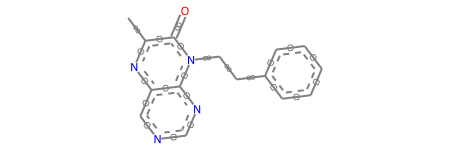

In [32]:
n_images = 5

highest_naa = MAIN.sort_values(by=['Nonadditivity_abs'], ascending=False).head(5)
highest_naa_tests = list(highest_naa.iloc[:n_images].values)

for c in highest_naa_tests:
    ids = c[0:4]
    ids = [str(i) for i in ids]
    smiles = c[4:8]
    tsmarts = c[9:11]
    pActs = c[12:16]
    pActs = [str(p) for p in pActs]
    Acts = ['']
    qualifiers = ['', '', '', '']
    nonadd = str(round(c[-1],1))
    target = c[8]

    cpds = [Chem.MolFromSmiles(smi) for smi in smiles]
    mcss_tot = Chem.MolFromSmarts(rdFMCS.FindMCS(cpds, completeRingsOnly=True, timeout=60).smartsString)
    AllChem.Compute2DCoords(mcss_tot)
    Chem.GetSymmSSSR(mcss_tot)
    display(mcss_tot)

    image_file = f'{name}_image_' + str('-'.join(ids)) + '.png'
    draw_image(ids, smiles, tsmarts, pActs, Acts, qualifiers, nonadd, mcss_tot, image_file, target)